# InsideAirbnb - London 

### Questions discussed in this report: 
1. Is Airbnb “out of control” in London?

2. How many professional landlords are there?

3. How many properties would be affected by the opposition’s proposal?

4. What are the likely pros and cons of the opposition’s proposal? (for the Mayor, for the residents, for the city)

5. Can the story be reframed as a positive one about social mobility or housing opportunity?


## 1. EDA

### 1.0. Caching Remote Data

In [2]:
# Import libraries needed for this analysis
from pathlib import Path
from requests import get
from functools import wraps
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager

ModuleNotFoundError: No module named 'geopandas'

In [4]:
def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        url = Path(src) 
        fn  = url.name  
        dsn = Path(f"{dst}/{fn}") 
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create...
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

### 1.1. Data Loading

#### 1.1.0 Read Data

In this section, we read data remotely with the caching function above.

In [5]:
# Set download URL
ymd  = '20250615'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
url  = f'{host}/~jreades/data/{ymd}-{city}-listings.csv.gz'

# Read csv data
df = pd.read_csv(url, compression='gzip', low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,651 x 79


In [6]:
ddir  = Path('data/geo') # destination directory
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath + 'Boroughs.gpkg?raw=true', ddir) )
water = gpd.read_file( cache_data(spath + 'Water.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath + 'Greenspace.gpkg?raw=true', ddir) )

print('Done.')

NameError: name 'gpd' is not defined

#### 1.1.1 Save Raw Data
Then, we want to save the raw Data in case we need them again in the later exploring.

In [7]:
# Create a diractory for raw data
path = Path(f'data/raw/{Path(url).name}') 
print(f"Writing to: {path}")

# Save raw data locally
if not path.parent.exists(): 
    print(f"Creating {path.parent}")
    path.parent.mkdir(parents=True, exist_ok=True)

if not path.exists():  
    df.to_csv(path, index=False)
    print("Done.")

Writing to: data/raw/20250615-London-listings.csv.gz


### 1.2 Data Processing

#### 1.2.0. Info

We run the chunk below to have a general sense of what are in the raw data, such as data type and columns.

In [8]:
# Get the information of the whole data set
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96651 entries, 0 to 96650
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            96651 non-null  int64  
 1   listing_url                                   96651 non-null  object 
 2   scrape_id                                     96651 non-null  int64  
 3   last_scraped                                  96651 non-null  object 
 4   source                                        96651 non-null  object 
 5   name                                          96651 non-null  object 
 6   description                                   93806 non-null  object 
 7   neighborhood_overview                         41983 non-null  object 
 8   picture_url                                   96642 non-null  object 
 9   host_id                                       96651 non-null 

In [9]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,9.665100e+04,9.665100e+04,9.665100e+04,96613.000000,96613.000000,0.0,96651.000000,96651.000000,96651.000000,62730.000000,...,71443.000000,71466.000000,71442.000000,71442.000000,0.0,96651.000000,96651.000000,96651.000000,96651.000000,71487.000000
mean,6.526020e+17,2.025061e+13,2.091790e+08,46.263577,76.334945,NaN,51.509818,-0.127087,3.316520,1.358018,...,4.792937,4.816368,4.733591,4.623804,NaN,16.389370,14.170831,2.164716,0.025763,0.958877
std,5.708808e+17,3.301970e+01,2.141266e+08,357.645418,561.614957,NaN,0.048945,0.100853,2.073674,0.725580,...,0.431668,0.423297,0.408804,0.506245,NaN,53.299577,52.845630,8.543681,0.626042,1.282595
min,1.391300e+04,2.025061e+13,2.594000e+03,1.000000,1.000000,NaN,51.295937,-0.496760,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.955518e+07,2.025061e+13,2.673176e+07,1.000000,1.000000,NaN,51.484240,-0.189060,2.000000,1.000000,...,4.760000,4.800000,4.650000,4.500000,NaN,1.000000,0.000000,0.000000,0.000000,0.150000
50%,8.123206e+17,2.025061e+13,1.128684e+08,2.000000,3.000000,NaN,51.513791,-0.126990,2.000000,1.000000,...,4.930000,4.970000,4.850000,4.750000,NaN,2.000000,1.000000,0.000000,0.000000,0.500000
75%,1.197378e+18,2.025061e+13,4.063762e+08,9.000000,14.000000,NaN,51.539099,-0.067880,4.000000,1.500000,...,5.000000,5.000000,5.000000,4.950000,NaN,8.000000,5.000000,1.000000,0.000000,1.230000
max,1.439673e+18,2.025061e+13,7.001298e+08,4884.000000,8723.000000,NaN,51.682630,0.278960,16.000000,26.000000,...,5.000000,5.000000,5.000000,5.000000,NaN,495.000000,495.000000,116.000000,25.000000,38.410000


#### 1.2.1. Columns

In [10]:
# Check columns in the data set
print(df.columns.to_list())

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

Given the result of columns above, we can tell there are many columns which are not useful for this analysis, therefore, we got `cols` below by copying the output of (`df.columns.to_list()`) and then removing the fields that we thought we weren’t interested in.

In [11]:
cols_selected = ['id', 'listing_url', 'source', 'description', 'host_id', 'host_name', 'host_is_superhost',
                'host_listings_count', 'calculated_host_listings_count', 
                 'room_type', 'property_type','accommodates', 'bedrooms', 
                 'beds', 'price', 'minimum_nights','maximum_nights',
                'estimated_occupancy_l365d', 'number_of_reviews', 'number_of_reviews_ltm', 'reviews_per_month',
                'review_scores_rating', 'latitude', 'longitude', 'neighbourhood_cleansed', 
                'host_total_listings_count', 'bathrooms', 'bathrooms_text', 
                'first_review', 'last_review']
len(cols_selected)

30

In [12]:
# Get a new df with selected cols
df = df[cols_selected]
print(f"The new data frame is {df.shape[0]:,} x {df.shape[1]}")

The new data frame is 96,651 x 30


#### 1.2.2. Dealing with NaNs and Nulls

Combined with results from `df.info()` and `df.describe()`, we see that a number of data types that aren’t ‘appropriate’ for their contents: the id columns are floats; the dates aren’t dates; there’s a boolean that’s not a boolean… It would be nice to fix these!

We started from exploring rows with NaN values. In the chunck below, we listed a exmaple from `price` columns. There are several more columns with the same issue, such `room_type` and `id`.

In [13]:
# Identify Problem Rows
df[df.price.isna()][['id','price','room_type']].head(3)

,id,price,room_type
12,271122,NaN,Private room
13,425143,NaN,Entire home/apt
16,427229,NaN,Private room


In [14]:
# There is no NaN in `id`
df[df.host_id.isna()][['id','host_id','price','room_type']]

,id,host_id,price,room_type


In [15]:
df[df.id.isna()][['id','price','room_type']]

,id,price,room_type


In [16]:
# Drop NaN
print(f"Data frame contains {df.shape[0]:,} rows.")
df.drop(df[df.host_id.isna()].index.array, axis=0, inplace=True)
print(f"Data frame contains {df.shape[0]:,} rows.")

Data frame contains 96,651 rows.
Data frame contains 96,651 rows.


We have checked there is no NaN values in `id` or in `host_id`, so we can now turn to counting NaNs or Nulls in the remaining data with a view to identifying other rows that can probably be dropped.

In [17]:
# returns a data frame with all values set to True/False according to Null status
df.isnull() 
# counts these values by column (we'll see another option in a moment)
df.isnull().sum(axis=0) 
# Sort results in descending order
df.isnull().sum(axis=0).sort_values(ascending=False) 

beds                              33975
price                             33967
bathrooms                         33921
last_review                       25164
review_scores_rating              25164
reviews_per_month                 25164
first_review                      25164
bedrooms                          12580
description                        2845
host_is_superhost                  1823
bathrooms_text                      149
host_name                            40
host_listings_count                  38
host_total_listings_count            38
number_of_reviews_ltm                 0
neighbourhood_cleansed                0
longitude                             0
latitude                              0
id                                    0
number_of_reviews                     0
estimated_occupancy_l365d             0
maximum_nights                        0
listing_url                           0
accommodates                          0
property_type                         0


We then drop the most obvious one: license.

In [18]:
#df.drop(columns=['license'], inplace=True)('license' is not selected)

In [19]:
# counting nulls by row
df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

4622     11
3646     11
6122     11
5535     11
5155     11
187      10
232      10
683      10
82       10
35147    10
dtype: int64

<class 'pandas.core.series.Series'>


<Axes: ylabel='Frequency'>

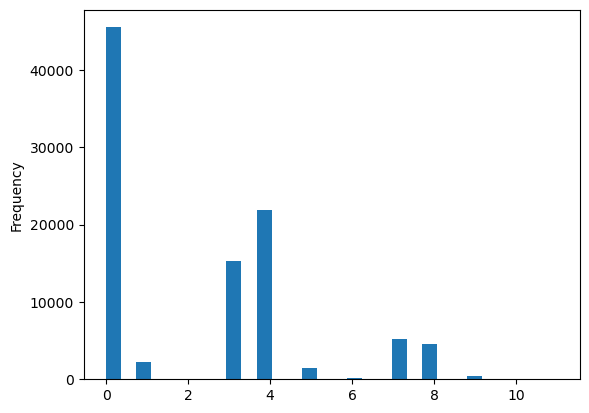

In [20]:
# save the results to a variable called probs
probs = df.isnull().sum(axis=1)
print(type(probs))       
probs.plot.hist(bins=30) 

Looking at this histogram, it is sensible to drop rows missing more than about 5 values on the basis that they are the ones that are most likely be problematic. We can use the index from probs to select out the rows we want to inspect from the main data frame.

In [19]:
# will be done later

'''
print(f"df contains {df.shape[0]:,} rows.")
cutoff = 5
df.drop(probs[probs > cutoff].index, inplace=True)
print(f"df contains {df.shape[0]:,} rows.")

'''

'\nprint(f"df contains {df.shape[0]:,} rows.")\ncutoff = 5\ndf.drop(probs[probs > cutoff].index, inplace=True)\nprint(f"df contains {df.shape[0]:,} rows.")\n\n'

#### 1.2.3. Fix Data Types

In [21]:
# Boolean
bools = ['host_is_superhost']
for b in bools:
    print(f"Converting {b}")
    df[b] = df[b].replace({'f':False, 't':True}).astype('bool')

Converting host_is_superhost


In [22]:
# Date
dates = ['first_review','last_review']
print(f"Currently {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")
for d in dates:
    print("Converting " + d)
    df[d] = pd.to_datetime(df[d])

print(f"Now {dates[1]} is of type '{df[dates[1]].dtype}'", "\n")


Currently last_review is of type 'object' 

Converting first_review
Converting last_review
Now last_review is of type 'datetime64[ns]' 




source：
 source
city scrape        62816
previous scrape    33835
Name: count, dtype: int64
review_is_NULL：
first_review    25164
last_review     25164
dtype: int64


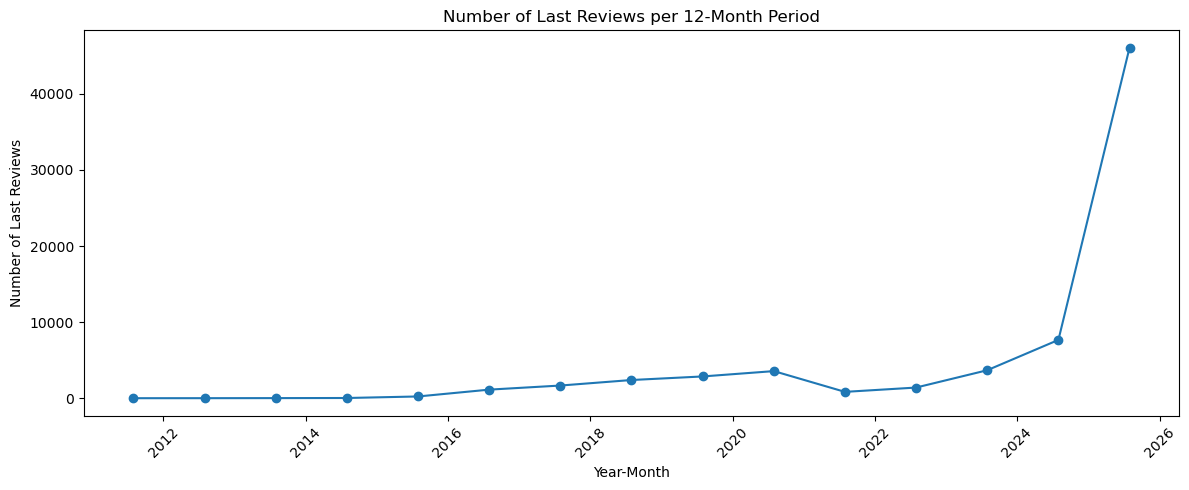

In [23]:
# year-number of last reviews,

source_counts = df['source'].value_counts()
print("\nsource：\n", source_counts)

review_cols = ['first_review', 'last_review']
na_counts = df[review_cols].isna().sum()

print("review_is_NULL：")
print(na_counts)

import matplotlib.pyplot as plt

monthly_counts = df.set_index('last_review').resample('12ME').size()

plt.figure(figsize=(12,5))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Number of Last Reviews')
plt.title('Number of Last Reviews per 12-Month Period')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



In [24]:
# counting review_time percentage
# validate active listings

now = pd.Timestamp('2025-06-15')
windows = [12, 24, 36, 48, 60, 72, 84]  

reviewed_listings = df[df['last_review'].notna()]
total_reviewed = reviewed_listings.shape[0]

print(f"listings_have_reviews: {total_reviewed}")
for w in windows:
    cutoff = now - pd.DateOffset(months=w)
    active_count = reviewed_listings[reviewed_listings['last_review'] >= cutoff].shape[0]
    active_ratio = active_count / total_reviewed * 100
    print(f"active last {w} month: {active_count}/{total_reviewed} → {active_ratio:.2f}%")


no_review_listings1 = df[df['last_review'].isna() & (df['number_of_reviews'].isna() | (df['number_of_reviews'] == 0))]
no_review_listings2 = df[df['last_review'].isna() & (df['number_of_reviews_ltm'].isna() | (df['number_of_reviews_ltm'] == 0))]
len(no_review_listings1)
len(no_review_listings2)

print("Listings with no first/last review = 0 reviews")
print("Only select out active listings (can be down later)")
# Listings with no first/last review = 0 reviews
# Only select out active listings (can be done later)

listings_have_reviews: 71487
active last 12 month: 48259/71487 → 67.51%
active last 24 month: 54758/71487 → 76.60%
active last 36 month: 57759/71487 → 80.80%
active last 48 month: 58889/71487 → 82.38%
active last 60 month: 59665/71487 → 83.46%
active last 72 month: 63751/71487 → 89.18%
active last 84 month: 66451/71487 → 92.96%
Listings with no first/last review = 0 reviews
Only select out active listings (can be down later)


In [25]:
# categories
cats = ['property_type','room_type']
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")
for c in cats:
    print(f"Converting {c}")
    df[c] = df[c].astype('category')
print(f"Currently {cats[1]} is of type '{df[cats[1]].dtype}'", "\n")

Currently room_type is of type 'object' 

Converting property_type
Converting room_type
Currently room_type is of type 'category' 



In [26]:
# These can be used for question 2: professional landlord
# compare with: calculated_host_listings_count,	
# calculated_host_listings_count_entire_homes,	
# calculated_host_listings_count_private_rooms,	
# calculated_host_listings_count_shared_rooms,	
print(df[cats[1]].cat.categories.values)
df[cats[0]].value_counts()
df[cats[1]].value_counts()

['Entire home/apt' 'Hotel room' 'Private room' 'Shared room']


room_type
Entire home/apt    62456
Private room       33893
Shared room          191
Hotel room           111
Name: count, dtype: int64

In [27]:
# strings
money = ['price']
for m in money:
    print(f"Converting {m}")    
    #df[m] = df[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')
    #报错了（）Can only use .str accessor with string values!略微改一下
    df[m] = df[m].astype(str).str.replace('$','', regex=False).str.replace(',','', regex=False) .astype(float)
    


Converting price


### JL - convert `bathroom_text` into integer 

In [28]:
# string

df["bathrooms_text"].unique()
df["bathrooms_text"] = df["bathrooms_text"].replace({
    "Shared half-bath": "0.5 shared baths",
    "Half-bath": "0.5 baths",
    "Private half-bath": "0.5 baths"
})

df["bathrooms_text"] = df["bathrooms_text"].astype(str)

df["bathrooms_text"] = (
    df["bathrooms_text"]
        .str.split(" ", n=1).str[0]
        .astype(float)
)

print("bathrooms null:", df["bathrooms"].isnull().sum())
print("bathrooms_text null:", df["bathrooms_text"].isnull().sum())

df = df.drop(columns=['bathrooms'])
df.rename(columns={'bathrooms_text': 'bathroom_new'}, inplace=True)

# bathrooms null: 33921
# bathrooms_text null: 149
# col "bathrooms_text" have more valid values

bathrooms null: 33921
bathrooms_text null: 149


### NOTE: JL - specify which columns need to be integer and check the float type

In [30]:

# col types
ints = ['id', 'host_id',
        'host_listings_count', 
        'accommodates', 'bedrooms', 'beds', 'minimum_nights','maximum_nights',
        'estimated_occupancy_l365d', 'number_of_reviews_ltm', 'reviews_per_month',
        'host_total_listings_count', 'bathroom_new', 'calculated_host_listings_count']

print(df[ints].dtypes)

id                                  int64
host_id                             int64
host_listings_count               float64
calculated_host_listings_count      int64
accommodates                        int64
bedrooms                          float64
beds                              float64
minimum_nights                      int64
maximum_nights                      int64
estimated_occupancy_l365d           int64
number_of_reviews_ltm               int64
reviews_per_month                 float64
host_total_listings_count         float64
bathrooms                         float64
bathrooms_text                    float64
dtype: object


In [31]:
# dealing with NULL/NAN/"" in numeric col
# transforming int type to UInt16(An extended form of int, allow keeping NULL)

#int_cols = [col for col in df.columns if str(df[col].dtype).startswith(('int', 'UInt'))]


#na_report = df[int_cols].isna().sum()

#print("number of NULL rows：")
#print(na_report)

#cols_with_nulls = ["host_listings_count", "bedrooms", "beds"]

#for col in cols_with_nulls:
#    df[col] = df[col].astype("UInt16") 

number of NULL rows：
id                                0
host_id                           0
calculated_host_listings_count    0
accommodates                      0
minimum_nights                    0
maximum_nights                    0
estimated_occupancy_l365d         0
number_of_reviews                 0
number_of_reviews_ltm             0
dtype: int64


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96651 entries, 0 to 96650
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              96651 non-null  int64         
 1   listing_url                     96651 non-null  object        
 2   source                          96651 non-null  object        
 3   description                     93806 non-null  object        
 4   host_id                         96651 non-null  int64         
 5   host_name                       96611 non-null  object        
 6   host_is_superhost               96651 non-null  bool          
 7   host_listings_count             96613 non-null  UInt16        
 8   calculated_host_listings_count  96651 non-null  int64         
 9   room_type                       96651 non-null  category      
 10  property_type                   96651 non-null  category      
 11  ac

### 1.3 Saving Clean Data

In [31]:
csv_out = Path(f'data/clean/{path.name}')
pq_out  = Path(f'data/clean/{path.name.replace('.csv.gz','.parquet')}')

if not csv_out.parent.exists():
    print(f"Creating {csv_out.parent}")
    csv_out.parent.mkdir(parents=True, exist_ok=True)
    
df.to_csv(csv_out, index=False)
df.to_parquet(pq_out, index=False)
print(f"Saved {df.shape[0]:,} rows of {df.shape[1]:,} columns to {csv_out.resolve()}")
print("Done.")

Saved 96,651 rows of 34 columns to /home/jovyan/work/Airbnb/data/clean/20250615-London-listings.csv.gz
Done.


### Data filtering
JL - bathrooms	bathrooms_text
对比空值数量，选空值少的一列 

last_review，一年/两年数量对比，选择肘点

### 1.3 Create Geo-Data Frame

The current data we have is not Geo-Data yet, since the data represents points and is provided with latitude and longitude (or similar) as separate columns in a non-geographic data set. Therefore, we need to convert our coordinates into some kind of geo-data with `GeoPandas` package.

In [32]:
# Write data into Geo-data and
# set the crs into '4326'
gdf = gpd.GeoDataFrame(df,
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

In [33]:
# We check types of dataframes 
print(type(gdf))
print(type(gdf.geometry))
print(gdf.geometry.iloc[:5])

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>
0    POINT (-0.01948 51.44306)
1    POINT (-0.01997 51.44284)
2    POINT (-0.02275 51.44359)
3    POINT (-0.02309 51.44355)
4    POINT (-0.02307 51.44333)
Name: geometry, dtype: geometry


In [34]:
# don't run this kernel if not neccesary...

'''
def check(host_id):
    official = (
        df.loc[df['host_id'] == host_id, 'calculated_host_listings_count_entire_homes']
        .dropna()
        .unique()
    )
    official = official[0] if len(official) > 0 else 0  # 如果官方缺失，就当 0

    counted = (df.loc[
        (df['host_id'] == host_id) &
        (df['room_type'] == 'Entire home/apt')
    ]).shape[0]

    return official == counted


all_host_ids = df['host_id'].unique()

mismatch = [hid for hid in all_host_ids if not check(hid)]

print("Mismatch number：", len(mismatch))
'''

# output = 0
# no mismatched count

'\ndef check(host_id):\n    official = (\n        df.loc[df[\'host_id\'] == host_id, \'calculated_host_listings_count_entire_homes\']\n        .dropna()\n        .unique()\n    )\n    official = official[0] if len(official) > 0 else 0  # 如果官方缺失，就当 0\n\n    counted = (df.loc[\n        (df[\'host_id\'] == host_id) &\n        (df[\'room_type\'] == \'Entire home/apt\')\n    ]).shape[0]\n\n    return official == counted\n\n\nall_host_ids = df[\'host_id\'].unique()\n\nmismatch = [hid for hid in all_host_ids if not check(hid)]\n\nprint("Mismatch number：", len(mismatch))\n'

In [33]:
# Verifyinh classification criteria of 'professional landlord'
# group by host_id
df_group_by_id = df.groupby('host_id')

group_1 = df_group_by_id.filter(lambda x: len(x) == 1)
group_2 = df_group_by_id.filter(lambda x: len(x) >= 2)

roomtype_ratio = group_2['room_type'].value_counts(normalize=True)
print(roomtype_ratio)


host_room_types = group_2.groupby('host_id')['room_type'].unique()

# select out host without Entire home/apt and Hotel room
hosts_no_entire = host_room_types[
    ~host_room_types.apply(lambda x: ('Entire home/apt' in x) or ('Hotel room' in x))
]

num_hosts_no_entire = len(hosts_no_entire)

total_hosts_group2 = group_2['host_id'].nunique()
ratio_no_entire = num_hosts_no_entire / total_hosts_group2

print("multi_host with no entire/hotel：", num_hosts_no_entire)
print("percentage multi_host with no entire/hotel：", ratio_no_entire)

# number of listings >= 2, but nearly 30% id among those listings only have shared room/private room.
# using >= 1 entire

room_type
Entire home/apt    0.661945
Private room       0.333120
Shared room        0.002941
Hotel room         0.001993
Name: proportion, dtype: float64
multi_host with no entire/hotel： 3133
percentage multi_host with no entire/hotel： 0.2893424455116365


In [34]:
# counting number of entire home/apt, then check for robustness
# sublet
# then check description text: are there any similarity for describing among 'professional hosts' and non pro?

host_room_counts = df_group_by_id['room_type'].value_counts().unstack(fill_value=0)
entire_or_hotel = host_room_counts['Entire home/apt'] + host_room_counts['Hotel room']

num_host_ge1 = (entire_or_hotel >= 1).sum()
num_host_ge2 = (entire_or_hotel >= 2).sum()


print("number of host with at least 1 entire home/Hotel room：", num_host_ge1)
print("number of host with at least 2 entire home/Hotel room：", num_host_ge2)

number of host with at least 1 entire home/Hotel room： 35953
number of host with at least 2 entire home/Hotel room： 5239


In [43]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# We don't use this but I point out where you *could*
from sklearn.preprocessing import OneHotEncoder 

In [38]:
# 分词器和lemmatizer
!pip install nltk
import nltk

try:
    from nltk.corpus import wordnet as wn
    from nltk.stem.wordnet import WordNetLemmatizer
    from nltk.corpus import stopwords
    stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    tokenizer = ToktokTokenizer()
except:
    nltk.download("stopwords")
    nltk.download("punkt_tab")
    nltk.download("averaged_perceptron_tagger_eng")
    from nltk.corpus import stopwords
    from nltk.corpus import wordnet as wn
    from nltk.stem.wordnet import WordNetLemmatizer
    stopwords.words('english')

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 500.2 kB/s eta 0:00:00a 0:00:01
    pytz (>dev)
         ~^
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [nltk]2/3 [nltk]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hayashida_kan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hayashida_kan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/hayashida_kan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
# 这是做word cloud的，这里暂时用不到（）
try: 
    from wordcloud import WordCloud
except:
    ! pip install wordcloud
import string
import unicodedata
from wordcloud import WordCloud, STOPWORDS

from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('Result!', "Here's my output...")

##### Result!

>Here's my output...


In [41]:
# analysing text similarity between pro/non_pro
# group_by
df_group_by_type = df.groupby('room_type')

cols_str_detect = ['host_id', 'room_type', 'description']
str_detect = df_group_by_type[cols_str_detect]

str_detect.head()

# 定义区分筛选条件：分为valid/invalid pro
valid_hosts = df[df['room_type'].isin(['Entire home/apt', 'Hotel room'])]['host_id'].unique()
invalid_hosts = df[~df['host_id'].isin(valid_hosts)]['host_id'].unique()
invalid_hosts = [h for h in invalid_hosts if (df['host_id'] == h).sum() > 1]

str_entire_home = df_group_by_type.get_group('Entire home/apt')[cols_str_detect]
str_hotel_room = df_group_by_type.get_group('Hotel room')[cols_str_detect]
str_shared_room = df_group_by_type.get_group('Shared room')[cols_str_detect]
str_private_room = df_group_by_type.get_group('Private room')[cols_str_detect]

# 用host_id是否valid过滤（避免index变动造成的影响）
str_entire_hotel = pd.concat(
    [
        str_entire_home[str_entire_home['host_id'].isin(valid_hosts)],
        str_hotel_room[str_hotel_room['host_id'].isin(valid_hosts)]
    ],
    ignore_index=True
)

print(str_entire_hotel.head())


str_shared_private = pd.concat(
    [
        str_shared_room[str_shared_room['host_id'].isin(invalid_hosts)],
        str_private_room[str_private_room['host_id'].isin(invalid_hosts)]
    ],
    ignore_index=True
)

print(str_shared_private.head())




/var/folders/vx/yr9m0q5x2gb6cz30c3ndskh80000gn/T/ipykernel_54183/1729824623.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_group_by_type = df.groupby('room_type')


   host_id        room_type                                        description
0  1389063  Entire home/apt  An extremely large and sunny four bedroom grou...
1  1389063  Entire home/apt  Recently refurbished sunny one bedroom first f...
2  1389063  Entire home/apt  A large and sunny two bedroom second floor apa...
3  1389063  Entire home/apt  A large and sunny two bedroom second floor apa...
4  1389063  Entire home/apt  Completely refurbished 2 bedroom apt to sleep ...
     host_id    room_type                                        description
0   34771444  Shared room  This is a bright double room within a new buil...
1   88569660  Shared room  My place is in central London E1, close to Tow...
2   24960812  Shared room  The 4 bedroom house has two rooms for guest ro...
3   45363496  Shared room  Enjoy easy access to popular shops and restaur...
4  303622628  Shared room  Light bright freshly decorated room within a l...


In [44]:
import re

cleaned = str_entire_hotel['description'].fillna("").apply(lambda x: BeautifulSoup(x, 'html.parser').get_text(" "))
lower = cleaned.str.lower()

# clean 标点特殊符号多余符号和emoji
pat = re.compile(r'[^a-z0-9\s]')
subbed = lower.apply(lambda x: pat.sub('', x))


In [45]:
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
tokens = lower.apply(word_tokenize)
tokens


from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()

lemmas = tokens.apply(lambda x: [lemmatizer.lemmatize(t) for t in x])

'''
as_markdown("Lemmatised", '\n\n>'.join(lemmas.str.join(' ').to_list()))
# 这里print会全出来，不必要时先不print。。。

print("\n\n")

'''


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hayashida_kan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hayashida_kan/nltk_data...


'\nas_markdown("Lemmatised", \'\n\n>\'.join(lemmas.str.join(\' \').to_list()))\n# 这里print会全出来，不必要时先不print。。。\n\nprint("\n\n")\n\n'

In [46]:
stopword_list = set(stopwords.words('english'))
print(stopword_list)

tokens = tokens.apply(lambda lst: [x for x in lst if x not in stopword_list and len(x)>1])


{'has', 'over', 'as', 'had', 'out', 'until', 'further', 'in', 'his', 'ma', 'her', 'needn', 'o', "i'll", 'this', "you'd", 'yours', 'of', 'few', "it'll", 'been', "i'd", "that'll", 'weren', 'haven', 'not', 'so', "they'd", 'between', 'didn', 'while', 'how', "she'll", "don't", 'myself', 'under', 'for', 'himself', "they've", "mustn't", 'all', "wasn't", 'which', 'nor', 'same', 'against', 'ourselves', 'other', 'a', 'he', 'hers', 'their', 'she', "mightn't", 'about', "wouldn't", 'll', 'what', 'very', 'aren', 'mustn', "isn't", 'your', 'having', 'these', 'did', 're', 'at', 'themselves', "we'll", 'be', 'shan', 'each', "hasn't", 'does', 'here', 'the', 'that', 'any', 'ours', "needn't", 'whom', 'have', 'some', "they'll", 'no', 'during', "won't", 'm', 'again', 'our', 'such', "she's", 'who', 'was', 'itself', "shouldn't", "doesn't", 'yourself', "didn't", "she'd", "it's", 'to', 'or', 'from', 's', 'by', 'because', "haven't", 'below', 'him', "should've", "he's", 'theirs', 'there', 'shouldn', 'wasn', 'when',

In [47]:
%load_ext autoreload
%autoreload 2

In [48]:
try: 
    from textual import *
except:
    try:
        from unidecode import unidecode
    except:
        ! pip install unidecode
    import urllib.request
    host  = 'https://orca.casa.ucl.ac.uk'
    turl  = f'{host}/~jreades/__textual__.py'
    tdirs = Path('textual')
    tpath = Path(tdirs / '__init__.py')

    if not tpath.exists():
        tdirs.mkdir(parents=True, exist_ok=True)
        urllib.request.urlretrieve(turl, tpath)
    from textual import *

    pytz (>dev)
         ~^
All NLTK libraries installed...


In [ ]:
str_entire_hotel['description'] = tokens.apply(normalise_document, remove_digits=True)

srcdf = str_entire_hotel['description']

corpus = srcdf.fillna(" ").values
print(corpus[0:3])

# 下面这部分没啥用，practice里有的但是是另外的示例，我们这里做用不到
'''
sentences = [nltk.sent_tokenize(text) for text in corpus]
words     = [[nltk.tokenize.word_tokenize(sentence) 
                  for sentence in nltk.sent_tokenize(text)] 
                  for text in corpus]

print(f"Sentences 0: {sentences[0]}")
print()
print(f"Words 0: {words[0]}")
'''

[list(['extremely', 'large', 'sunny', 'four', 'bedroom', 'ground', 'floor', 'apartment', 'perfect', 'large/extended', 'families', 'group', 'well', 'located', 'enjoy', 'delights', 'london', 'yet', 'home', 'home', 'environment', 'brings', 'guests', 'back', 'year', 'year'])
 list(['recently', 'refurbished', 'sunny', 'one', 'bedroom', 'first', 'floor', 'apartment'])
 list(['large', 'sunny', 'two', 'bedroom', 'second', 'floor', 'apartment', 'perfect', 'family', 'well', 'located', 'enjoy', 'delights', 'london', 'yet', 'home', 'home', 'environment', 'brings', 'guests', 'back', 'year', 'year', 'september', '2018', 'total', 'redec', 'new', 'kitchen', 'flooring', 'throughout'])]


'\nsentences = [nltk.sent_tokenize(text) for text in corpus]\nwords     = [[nltk.tokenize.word_tokenize(sentence) \n                  for sentence in nltk.sent_tokenize(text)] \n                  for text in corpus]\n\nprint(f"Sentences 0: {sentences[0]}")\nprint()\nprint(f"Words 0: {words[0]}")\n'

In [71]:
# 前面的清理步骤建议直接写成一个函数，有用的基本就是这些，更直观，可以直接用，如下：
# str_shared_private['description_clean'] = clean_text(str_shared_private['description'])


def clean_text(text):
    cleaned = text.fillna("").apply(lambda x: BeautifulSoup(x, 'html.parser').get_text(" "))
    lower = cleaned.str.lower()
    pat = re.compile(r'[^a-z0-9\s]')
    no_punct = lower.apply(lambda x: pat.sub('', x))
    tokens = lower.apply(word_tokenize)
    tokens = tokens.apply(lambda x: [lemmatizer.lemmatize(t) for t in x])
    tokens = tokens.apply(lambda lst: [x for x in lst if x not in stopword_list])
    normalised = tokens.apply(normalise_document, remove_digits=True)
    normalised_str = normalised.apply(lambda lst: ' '.join(lst))
    return normalised_str

In [52]:
fcounts = dict()

data = nltk.tokenize.word_tokenize(
    ' '.join([str(text).replace('.', '') for text in corpus])
)


for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})


<FreqDist with 34288 samples and 7308920 outcomes>
<FreqDist with 71203 samples and 7308919 outcomes>
<FreqDist with 113893 samples and 7308918 outcomes>


In [53]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))
    print()

            Ngram Size 1
'                2398055
,                2343059
[                  62567
]                  62567
'london            51051
'walk              29609
'apartment         27945
'flat              27427
'station           22698
'bedroom           20939

                       Ngram Size 2
'          ,                2323215
]          [                  62566
'          ]                  60564
'london    '                  51045
,          'london            50979
'walk      '                  29609
,          'walk              29598
'apartment '                  27945
'flat      '                  27426
,          'apartment         27307

                                  Ngram Size 3
'          ]          [                  60563
,          'london    '                  50979
'          ,          'london            50926
'london    '          ,                  47692
,          'walk      '                  29598
'          ,          'walk              2948

In [58]:

from sklearn.feature_extraction.text import CountVectorizer

corpus = [str(x) for x in corpus]
cvectorizer = CountVectorizer()
cvectorizer.fit(corpus)
pd.options.display.max_colwidth=750



cvtcorpus = cvectorizer.transform(corpus)
cvtcorpus # cvtcorpus for count-vectorised transformed corpus

doc_df = pd.DataFrame(cvtcorpus[0].T.todense(), 
                      index=cvectorizer.get_feature_names_out(), columns=["Counts"]
                     ).sort_values('Counts', ascending=False)
doc_df.head(50)


cvdf = pd.DataFrame(data=cvtcorpus.toarray(),
                        columns=cvectorizer.get_feature_names_out())
print(f"Raw count vectorised data frame has {cvdf.shape[0]:,} rows and {cvdf.shape[1]:,} columns.")
cvdf.iloc[0:3,0:7]


sums = cvdf.sum(axis=0)
print(f"There are {len(sums):,} terms in the data set.")
sums.head()

filter_terms = sums >= cvdf.shape[0] * 0.01
fcvdf = cvdf.drop(columns=cvdf.columns[~filter_terms].values)
print(f"Filtered count vectorised data frame has {fcvdf.shape[0]:,} rows and {fcvdf.shape[1]:,} columns.")
fcvdf.iloc[0:3,0:7]
fcvdf.sum(axis=0)

Raw count vectorised data frame has 62,567 rows and 22,613 columns.
There are 22,613 terms in the data set.
Filtered count vectorised data frame has 62,567 rows and 631 columns.


10         8247
12         1253
15         4999
20         3856
24         1950
           ... 
working    1072
world      1387
would       937
yet        1029
zone       2185
Length: 631, dtype: int64

In [60]:
# 


# str_detect
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re

# n-gram + TF-IDF identifyer
vectorizer = TfidfVectorizer(
    ngram_range = (1, 3),   # unigram + bigram + trigram
    max_df = 0.95,          # drop words which occured in 95%+ listings
    min_df = 0.0005,         
    stop_words = 'english'
)

tfidf_matrix = vectorizer.fit_transform(corpus)

feature_names = np.array(vectorizer.get_feature_names_out())
avg_tfidf = tfidf_matrix.mean(axis=0).A1  # 计算每列平均值
tfidf_df = pd.DataFrame({'ngram': feature_names, 'avg_tfidf': avg_tfidf})

# rank based on TF-IDF mean value，get top 50 words
top_ngrams = tfidf_df.sort_values(by='avg_tfidf', ascending=False).head(52)
print(top_ngrams)

                ngram  avg_tfidf
8947           london   0.029020
5761             flat   0.021758
765         apartment   0.021681
15959            walk   0.020817
1949          bedroom   0.020591
8698          located   0.018390
14077         station   0.017192
10075         minutes   0.016491
1804              bed   0.016129
7210             home   0.015672
7918          kitchen   0.015203
2982          central   0.014950
11617           place   0.014728
14298            stay   0.014136
11398         perfect   0.014069
12746            room   0.013873
8551           living   0.013871
11118            park   0.013719
10213          modern   0.013675
14495          street   0.013421
13828        spacious   0.013162
1056             area   0.013112
1305             away   0.012884
4962            enjoy   0.012454
14738         stylish   0.012226
13740           space   0.012195
2998   central london   0.012054
3416            close   0.011933
6363           garden   0.011835
4594      

In [61]:
# delete outliers

top_ngrams = top_ngrams[~top_ngrams['ngram'].str.contains(r'\bbr\b')]
print(top_ngrams)

                ngram  avg_tfidf
8947           london   0.029020
5761             flat   0.021758
765         apartment   0.021681
15959            walk   0.020817
1949          bedroom   0.020591
8698          located   0.018390
14077         station   0.017192
10075         minutes   0.016491
1804              bed   0.016129
7210             home   0.015672
7918          kitchen   0.015203
2982          central   0.014950
11617           place   0.014728
14298            stay   0.014136
11398         perfect   0.014069
12746            room   0.013873
8551           living   0.013871
11118            park   0.013719
10213          modern   0.013675
14495          street   0.013421
13828        spacious   0.013162
1056             area   0.013112
1305             away   0.012884
4962            enjoy   0.012454
14738         stylish   0.012226
13740           space   0.012195
2998   central london   0.012054
3416            close   0.011933
6363           garden   0.011835
4594      

In [72]:
# calculate similarity (on shared/private listings)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

top_keywords = list(top_ngrams['ngram'])
top_keywords_set = set(top_keywords)

str_shared_private['description'] = str_shared_private['description'].fillna('').astype(str)
str_shared_private['description'] = clean_text(str_shared_private['description'])

# method: jaccard
# 这个方法只词频不加权重，cosine的也看权重，这里两个结合作为判断标准。一般来说cosine即可
def jaccard_similarity(text):
    words = set(text.split())
    if not words:
        return 0
    intersection = words & top_keywords_set
    union = words | top_keywords_set
    return len(intersection) / len(union)


str_shared_private['jaccard_sim'] = str_shared_private['description'].apply(jaccard_similarity)


vectorizer = TfidfVectorizer(vocabulary=top_keywords)
X_unknown = vectorizer.fit_transform(str_shared_private['description'])


top_vec = np.ones((1, len(top_keywords)))
top_vec = top_vec / np.linalg.norm(top_vec)

# method: cosine
cos_sim = cosine_similarity(X_unknown, top_vec)
str_shared_private['tfidf_cos_sim'] = cos_sim[:, 0]

# tail(top n% similarity, n can be reset)
jaccard_thresh = str_shared_private['jaccard_sim'].quantile(0.90)
cosine_thresh = str_shared_private['tfidf_cos_sim'].quantile(0.90)


high_sim_entries = str_shared_private[
    (str_shared_private['jaccard_sim'] >= jaccard_thresh) &
    (str_shared_private['tfidf_cos_sim'] >= cosine_thresh)
]

print(high_sim_entries[['description', 'jaccard_sim', 'tfidf_cos_sim']])

                                                                                                                                                                                                                                                                                                                                                                                 description  \
106                                                      need night sleep freshen get affordable price yet prime central location perfect place ideal sleeping couch centrally located heart stratford highrise bright stylish single bed living room area adjacent open kitchen shared place large shared bathroom tub building surrounded hotel hostel bus stop stratford dlr station near   
174                                                   enjoy quiet xl attic space 3 walk bound green tube station 18 min king x st pancras kitchen direct access central london city old street shoreditch major airport railway station 

In [73]:
str_shared_private[['jaccard_sim','tfidf_cos_sim']].describe()

,jaccard_sim,tfidf_cos_sim
count,9874.000000,9874.000000
mean,0.106769,0.358845
std,0.052802,0.120796
min,0.000000,0.000000
25%,0.071429,0.303149
50%,0.107143,0.380094
75%,0.141176,0.440225
max,0.309859,0.643196


In [74]:
high_sim_entries_jac = str_shared_private[
    (str_shared_private['jaccard_sim'] >= jaccard_thresh)
]
high_sim_entries_cos = str_shared_private[
    (str_shared_private['jaccard_sim'] >= jaccard_thresh)
]

print(high_sim_entries_cos[['description', 'jaccard_sim', 'tfidf_cos_sim']])

                                                                                                                                                                                                                                                                                                                                                                                 description  \
106                                                      need night sleep freshen get affordable price yet prime central location perfect place ideal sleeping couch centrally located heart stratford highrise bright stylish single bed living room area adjacent open kitchen shared place large shared bathroom tub building surrounded hotel hostel bus stop stratford dlr station near   
174                                                   enjoy quiet xl attic space 3 walk bound green tube station 18 min king x st pancras kitchen direct access central london city old street shoreditch major airport railway station 